
# Bayesian A/B testing

**Problem Summary:**

As an online retailer operating two stores, we've decided to increase the price of a specific product in one of the stores. We're keen to understand the impact of this price increase on our sales volume. Specifically, we want to investigate whether the price increase has led to a significant decrease in sales. Given the two-store setup, this problem presents a classic opportunity for an A/B test, where one store serves as the control group (with the original price) and the other as the test or treatment group (with the increased price). Or, we can also test the sales before and after the price change, we will see this has some problems though...

Our primary aim is to use A/B testing to ascertain whether the observed differences in sales volume (if any) are statistically significant, and therefore likely due to the price increase rather than random variation. This knowledge will inform our pricing strategies moving forward and ensure we're making data-driven decisions that maximize our revenue without adversely affecting sales volume.

As usual, there are many ways to define a problem, below we will see some examples

# Load and Display Sales Data
Load sales data generated with `src/generate_dataset.py` and display the sales

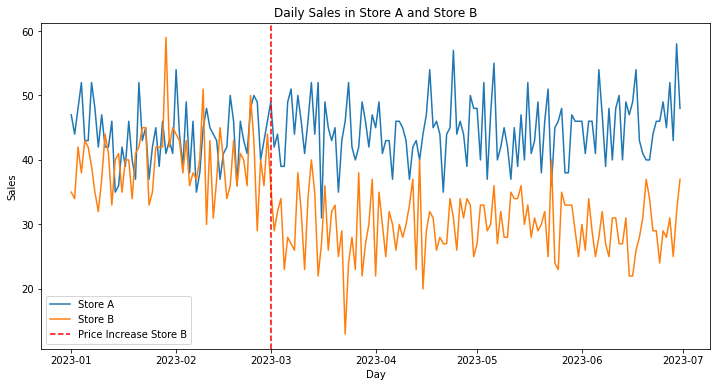

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data_daily_normal_loaded = pd.read_csv('data/daily_sales_data_normal.csv')

# Convert the 'Day' column back to datetime format
data_daily_normal_loaded['Day'] = pd.to_datetime(data_daily_normal_loaded['Day'])

# Add a column indicating if the price change is in effect in Store B
data_daily_normal_loaded['Price Change Store B'] = data_daily_normal_loaded['Day'].apply(lambda x: 'Before' if x < pd.Timestamp('2023-03-01') else 'After')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the sales data for Store A and Store B
ax.plot(data_daily_normal_loaded['Day'], data_daily_normal_loaded['Sales_Store_A'], label='Store A')
ax.plot(data_daily_normal_loaded['Day'], data_daily_normal_loaded['Sales_Store_B'], label='Store B')

# Add a vertical line to indicate when the price change occurred
ax.axvline(pd.Timestamp('2023-03-01'), color='red', linestyle='--', label='Price Increase Store B')

# Add labels and a legend
ax.set_xlabel('Day')
ax.set_ylabel('Sales')
ax.set_title('Daily Sales in Store A and Store B')
ax.legend()

plt.show()



In Bayesian A/B testing, we start with a prior belief about the parameter we're interested in (in this case, the difference in sales between Store A and Store B), and we update this belief using our observed data.
Bayesian methods involve working with probability distributions. For this problem, since we are dealing with sales data (counts), we might use a Poisson distribution as our likelihood function, since the Poisson distribution is often used for modeling count data. 
However, it's important to note that Bayesian analysis can be more computationally intensive than frequentist methods, and the results can be more sensitive to the choice of prior.
Sure, let's improve the example to better reflect the Bayesian A/B testing process. 
In Bayesian A/B testing, we have two main steps:

1. Prior distribution: Here we express what we believe about the parameter before seeing the data. In this case, our parameters are the means and standard deviations of the sales of stores A and B.
2. Likelihood function: This expresses how we think our data was generated. Here, we can use the Normal distribution as our likelihood function, since we believe that sales follow a Normal distribution.

We can use weakly informative priors, meaning that these priors don't affect the posterior too much. Here, we can use a Normal distribution with mean 0 and large standard deviation (like 100) for the means, and HalfCauchy with beta = 5 for the standard deviations.




Let's proceed with a simplified version of this analysis. We'll assume that the sales in each store follow a normal distribution, and we'll use a normal distribution as our prior for the difference in sales. This will allow us to use a conjugate prior, which simplifies the calculations.

We will use `numpyro` for this
>numpyro, which is a probabilistic programming library that uses JAX for automatic differentiation and JIT compilation to GPU/TPU/CPU.
>However, keep in mind that:
>1. Bayesian analysis tends to be more computationally intensive than frequentist methods, and the exact computation time will depend on the specific problem and the specifics of your computational environment.
>2. The script runs a Markov chain Monte Carlo (MCMC) algorithm to sample from the posterior distribution


The magic happens in this line:

`numpyro.sample('sales_A_obs', dist.Normal(mu_A, sigma_A), obs=sales_A)` is used to define the likelihood function in the `numpyro` model.

Let's break it down:

- `numpyro.sample`: This is a function used in `numpyro` to draw a sample from a probability distribution. When used in a model definition, it represents a random variable.
- `'sales_A_obs'`: This is the name of the random variable. You can use it later to refer to this variable.
- `dist.Normal(mu_A, sigma_A)`: This specifies that the random variable follows a Normal distribution with mean `mu_A` and standard deviation `sigma_A`. These are the parameters of the distribution that the model will try to learn.
- `obs=sales_A`: This is the observed data for this random variable. When you provide observed data with the `obs` argument, `numpyro` uses this data to update the beliefs about the parameters of the distribution (`mu_A` and `sigma_A` in this case) during the model fitting process.

In the context of the model, this line is saying that we believe the sales data from Store A (`sales_A`) are generated from a Normal distribution, and we want to learn the parameters of this distribution (`mu_A` and `sigma_A`). When we fit the model with MCMC, `numpyro` will use the observed sales data to update our beliefs about these parameters.

In [7]:
import pandas as pd
import numpy as np
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# Load the data from the CSV file
data_daily_normal_loaded = pd.read_csv('data/daily_sales_data_normal.csv')

# Convert the 'Day' column back to datetime format
data_daily_normal_loaded['Day'] = pd.to_datetime(data_daily_normal_loaded['Day'])

# Separate the data into Store A and Store B after the price change
sales_A = data_daily_normal_loaded.loc[data_daily_normal_loaded['Day'] >= '2023-03-01', 'Sales_Store_A'].values
sales_B = data_daily_normal_loaded.loc[data_daily_normal_loaded['Day'] >= '2023-03-01', 'Sales_Store_B'].values

def model(sales_A, sales_B):
    mu_A = numpyro.sample('mu_A', dist.Normal(0, 100))
    mu_B = numpyro.sample('mu_B', dist.Normal(0, 100))
    sigma_A = numpyro.sample('sigma_A', dist.HalfCauchy(5))
    sigma_B = numpyro.sample('sigma_B', dist.HalfCauchy(5))
    # here we learn the distirbutoin of sales_A with a base assumption that is a normal
    numpyro.sample('sales_A_obs', dist.Normal(mu_A, sigma_A), obs=sales_A)
    numpyro.sample('sales_B_obs', dist.Normal(mu_B, sigma_B), obs=sales_B)

# Run MCMC
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=2000)
mcmc.run(jax.random.PRNGKey(0), sales_A=sales_A, sales_B=sales_B)
mcmc.print_summary()


sample: 100%|██████████| 2500/2500 [00:02<00:00, 990.55it/s, 7 steps of size 8.02e-01. acc. prob=0.91] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_A     44.77      0.43     44.75     44.04     45.49   2100.30      1.00
      mu_B     29.68      0.42     29.68     29.05     30.41   2466.95      1.00
   sigma_A      4.85      0.31      4.83      4.34      5.35   1889.89      1.00
   sigma_B      4.70      0.29      4.69      4.22      5.13   1633.79      1.00

Number of divergences: 0



> The *Cauchy distribution* is a symmetric distribution that looks similar to the normal distribution, but it has heavier tails, meaning it is more prone to producing values that fall far from its mean (i.e., it can produce more outliers). 
>1. *When we "half" the Cauchy distribution, we only consider the positive part of the distribution*. This makes the Half-Cauchy distribution useful as a prior for scale parameters (like standard deviations) that are always non-negative.
>2. In the context of Bayesian analysis, the Half-Cauchy distribution is often used as a weakly informative prior for scale parameters (like the standard deviation of a normal distribution). It's considered "weakly informative" because it doesn't add strong assumptions to the model: it allows the parameter to be almost any positive value, but it slightly prefers smaller values over larger ones.


The output of the function `mcmc.print_summary()` provides a summary of the posterior distributions of the model parameters after running the Markov Chain Monte Carlo (MCMC) simulations.

Here's a brief description of what the columns in the summary output represent:

- `mean`: This is the mean (or expected value) of the posterior distribution of the parameter. It represents the average value of the parameter given the data.

- `sd`: This is the standard deviation of the posterior distribution of the parameter. It represents the uncertainty or variability in the estimate of the parameter.

- `hpd_5%` and `hpd_95%`: These are the 5th and 95th percentiles of the posterior distribution, providing a 95+% Highest Posterior Density Interval (HPDI). An HPDI is a Bayesian version of a confidence interval. It represents the range within which the true parameter value lies with a 95+% probability.

- `n_eff`: This is the effective sample size. It represents the number of effectively independent draws from the posterior distribution that the MCMC algorithm achieved. A larger effective sample size means that the MCMC sampling has been more effective.

- `Rhat`: This is the potential scale reduction factor. It is used to check the convergence of the MCMC algorithm. A value close to 1 indicates that the MCMC algorithm has converged.

In the context of the A/B test, the `mean` of the parameter `mu_B - mu_A` tells us the expected difference in the average sales of Store B and Store A after the price change, given the observed data. If this value is negative, it suggests that the price increase had a negative impact on sales in Store B. The `sd`, `hpd_5%`, and `hpd_95%` provide a measure of the uncertainty in this estimate.

## Refuting the null hyphotesis

The null hypothesis in our A/B testing scenario is that the price change has no effect on sales, which means the average sales of Store A and Store B are the same, even after the price change. 

In the context of Bayesian analysis, we can evaluate this null hypothesis by looking at the posterior distribution of the difference in means (mu_B - mu_A). If the null hypothesis is true, we would expect the difference in means to be around zero. 

Therefore, to evaluate the null hypothesis, we can check if zero is included in the Highest Posterior Density Interval (HPDI) of the difference in means. If zero is not in the 95% HPDI (i.e., it's not between the `hpd_5%` and `hpd_95%` values), we can reject the null hypothesis at the 95% confidence level.

Alternatively, we can look at the posterior distribution of the difference in means. If the distribution is mostly above or mostly below zero, this gives evidence against the null hypothesis. For example, if the `mean` of the difference in means is negative and the `hpd_5%` and `hpd_95%` values are also negative, this suggests that the price increase had a negative impact on sales in Store B.

Remember, in Bayesian analysis, we don't "accept" or "reject" hypotheses in the same way as in frequentist hypothesis testing. Instead, we update our beliefs about the parameters (in this case, the difference in means) in light of the observed data, and make probabilistic statements based on the posterior distributions of the parameters.

## Visualise the prior distributions assumed

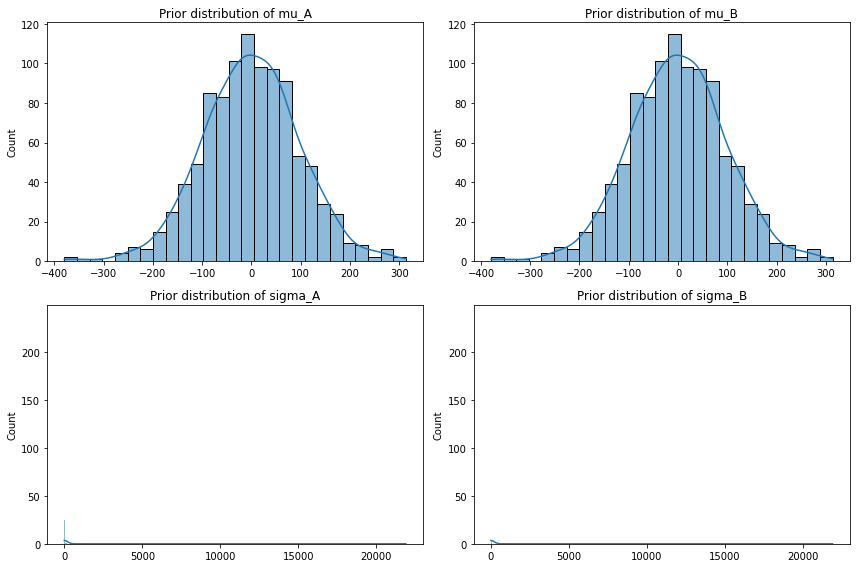

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample from the prior distributions
prior_samples = {
    'mu_A': dist.Normal(0, 100).sample(jax.random.PRNGKey(0), (1000,)),
    'mu_B': dist.Normal(0, 100).sample(jax.random.PRNGKey(0), (1000,)),
    'sigma_A': dist.HalfCauchy(5).sample(jax.random.PRNGKey(0), (1000,)),
    'sigma_B': dist.HalfCauchy(5).sample(jax.random.PRNGKey(0), (1000,)),
}

# Plot the prior distributions
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ax, (param, samples) in zip(axs.ravel(), prior_samples.items()):
    sns.histplot(samples, ax=ax, kde=True)
    ax.set_title(f'Prior distribution of {param}')

plt.tight_layout()
plt.show()


# Visualise the posterior samples, after adapting the priors with the data

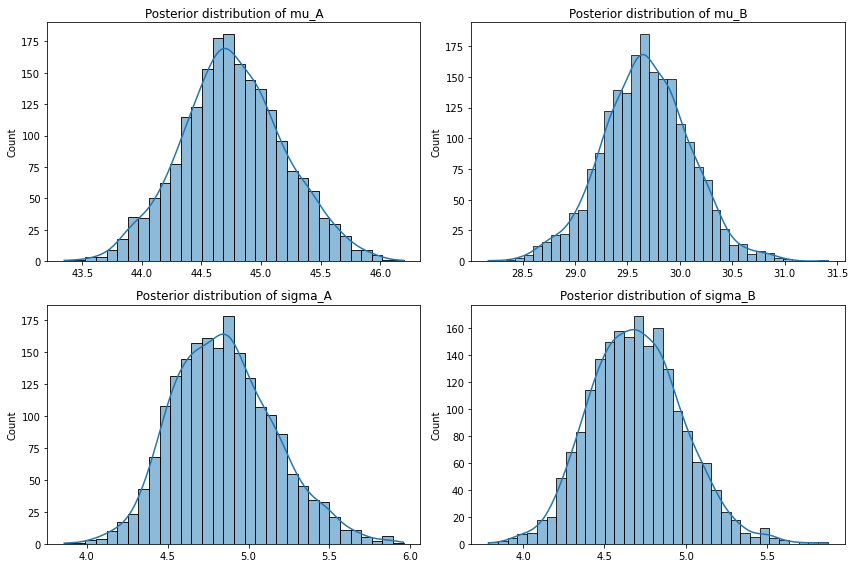

In [9]:
posterior_samples = mcmc.get_samples()

import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ax, (param, samples) in zip(axs.ravel(), posterior_samples.items()):
    sns.histplot(samples, ax=ax, kde=True)
    ax.set_title(f'Posterior distribution of {param}')

plt.tight_layout()
plt.show()


This code generates a histogram and a kernel density estimate for each of the parameters. The histograms give you a visual representation of the distribution of the samples, while the kernel density estimates give a smooth approximation of the distribution.
Please note that the quality of the posterior estimates will depend on the convergence of the MCMC algorithm. You should check the diagnostics (like the n_eff and Rhat values from the mcmc.print_summary() output) to make sure the MCMC algorithm has converged.




